## Resumo da modelagem de dados do projeto


    A parte do projeto relativa à obtenção, análise e processamento de dados ocorreu da seguinte forma:
    
    
Inicialmente pesquisamos bases de dados no Brasil e no mundo que contivessem dados de orçamento doméstico. Os dados encontrados mais próximos dos que seriam utilizados numa aplicação real, foram dados de orçamento e composição de famílias filipinas encontradas na plaforma Kaggle. 

A partir desta base de dados pública foi feita uma seleção de variáveis numéricas importantes para o problema. O objetivo visado foi encontrar tendências de gasto de uma família dado sua composição familiar por idade, número de pessoas trabalhando e renda total familiar, que é a principal variável do problema, e sugerir a um novo usuário (família no caso da nossa base de dados e pessoa física no caso da Nubank) um valor médio de gasto por categoria dados outros usuários de características semelhantes. Para entendermos melhor nossos dados, fizemos análises exploratórias tais como distribuição de probabilidade, análise de correlação com outras variáveis em mapa de calor. Outra análise importante que foi feita e vale destacar foi a composição de gastos por categoria em cada região geográfica, o que evidencia fortes diferenças entre regiões ricas e pobres. Estes dados de região não foram utilizados no modelo que foi desenvolvido por tratar-se de um protótipo, mas certamente sua utilização aportaria melhoras significativas numa aplicação real. 

Em seguida, na etapa de pré-processamento foi feita uma redução de dimensão com a técnica de principal component analysis de 5 para 3 no intuito de eliminar dimensões de menor variância e tornar possível a visualização do conjunto de dados no espaço tridimensional. Feito isso, utilizamos a técnica de clustering K-means para separar as famílias em 3 grupos (clusters), nos quais foram feitos regressões lineares por categoria de gastos. A ideia por trás da escolha desses algoritmos foi que ao receber um novo usuário na plaforma ele seria alocado dinamicamente em um cluster, que apresentaria perfil familiar e de gastos mais próximos do seu e a feature proposta em nosso projeto usaria a reta de tendência do cluster para sugerir um valor inicial de gasto em cada categoria para este usuário, que poderia a partir desse valor inicial adaptar os gastos segundo suas necessidades particulares. A escolha deste modelo linear foi feita porque não é intuito do projeto prever o gasto exato ou aproximado em cada categoria de determinado usuário, mas o de ajudar  o usuário a gastar melhor e com mais consciência. Dessa forma, o fato de ele ter características muito próximas de outros usuários, mas gastar excessivamente em alguma categoria indica necessidades especiais deste usuário, pontuais ou permanentes, ou um descontrole financeiro em alguns itens de compra. Um dos nosso objetivos ao propor o projeto é justamente identificar e ajudar usuários que se enquadrem nesta última situação e cremos que o modelo de regressão linear em clusters seria o modelo mais simples a cumprir este papel proposto.


In [1]:
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import cluster
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
from cycler import cycler

In [2]:
# Base de dados filipina de renda familiar e gastos anuais categorizados
# Fonte: https://www.kaggle.com/grosvenpaul/family-income-and-expenditure/kernels
df = pd.read_csv("Family Income and Expenditure.csv")

In [3]:
df.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 60 columns):
Total Household Income                           41544 non-null int64
Region                                           41544 non-null object
Total Food Expenditure                           41544 non-null int64
Main Source of Income                            41544 non-null object
Agricultural Household indicator                 41544 non-null int64
Bread and Cereals Expenditure                    41544 non-null int64
Total Rice Expenditure                           41544 non-null int64
Meat Expenditure                                 41544 non-null int64
Total Fish and  marine products Expenditure      41544 non-null int64
Fruit Expenditure                                41544 non-null int64
Vegetables Expenditure                           41544 non-null int64
Restaurant and hotels Expenditure                41544 non-null int64
Alcoholic Beverages Expenditure                  

In [5]:
# Ideia da seleção de features: Usar renda familiar e dados de pessoas / idade e familiares empregados 
# para prever gasto por categoria

features_list = ['Total Household Income', 
                 'Total Number of Family members',
        'Members with age less than 5 year old',
       'Members with age 5 - 17 years old',
       'Total number of family members employed',
       
       'Total Food Expenditure', 
       'Restaurant and hotels Expenditure',
       'Alcoholic Beverages Expenditure',
       'Clothing, Footwear and Other Wear Expenditure',
       'Housing and water Expenditure', 
       'Medical Care Expenditure', 
       'Transportation Expenditure',
       'Communication Expenditure', 
       'Education Expenditure',
       'Miscellaneous Goods and Services Expenditure',
       'Special Occasions Expenditure'
]

print('Features utilizadas:', len(features_list))

Features utilizadas: 16


In [6]:
df_tri = df[features_list]

In [7]:
df_tri.describe()

,Total Household Income,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,Total Food Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure
count,4.154400e+04,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,4.154400e+04,4.154400e+04,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000
mean,2.475556e+05,4.635182,0.410216,1.362579,1.272699,85099.158194,15436.566075,1085.068121,4954.621076,3.837547e+04,7.160231e+03,11806.344454,4095.492057,7473.500481,12522.071635,5265.726001
std,2.868805e+05,2.280252,0.694390,1.408000,1.149152,51637.947682,23705.195929,2174.431913,7496.500945,5.311168e+04,2.690200e+04,19351.213715,7298.822614,21219.170907,17547.027921,13279.593681
min,1.128500e+04,1.000000,0.000000,0.000000,0.000000,2947.000000,0.000000,0.000000,0.000000,1.950000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.048950e+05,3.000000,0.000000,0.000000,0.000000,51017.250000,1930.000000,0.000000,1365.000000,1.308000e+04,3.000000e+02,2412.000000,564.000000,0.000000,3792.000000,0.000000
50%,1.640795e+05,4.000000,0.000000,1.000000,1.000000,72985.500000,7314.000000,270.000000,2740.000000,2.299200e+04,1.125000e+03,6036.000000,1506.000000,880.000000,6804.000000,1500.000000
75%,2.911385e+05,6.000000,1.000000,2.000000,2.000000,105635.500000,19921.250000,1299.250000,5580.000000,4.594800e+04,4.680000e+03,13776.000000,3900.000000,4060.000000,14154.000000,5000.000000
max,1.181599e+07,26.000000,5.000000,8.000000,8.000000,827565.000000,725296.000000,59592.000000,356750.000000,2.188560e+06,1.049275e+06,834996.000000,149940.000000,731000.000000,553560.000000,556700.000000


In [8]:
target = 'Total Household Income'
df_tri[target].describe()

count    4.154400e+04
mean     2.475556e+05
std      2.868805e+05
min      1.128500e+04
25%      1.048950e+05
50%      1.640795e+05
75%      2.911385e+05
max      1.181599e+07
Name: Total Household Income, dtype: float64

## Análise de Dados Exploratória

Abaixo serão explorados os principais parâmetros a serem utilizados no modelo preditivo de gastos categorizados

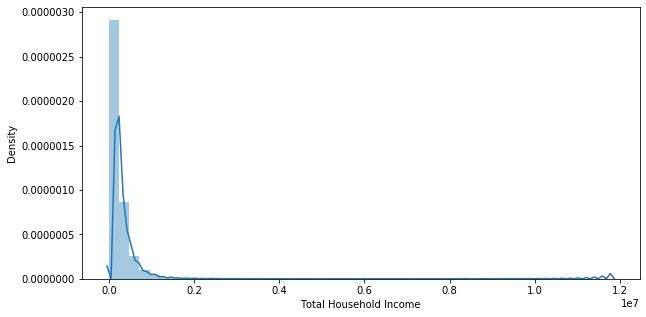

In [9]:
# Distribuição de probabilidade das observações de 'Total House Income'

plt.subplots(figsize=(10, 5))
s = sns.distplot(df_tri[target])
s.set(ylabel='Density')
plt.show()

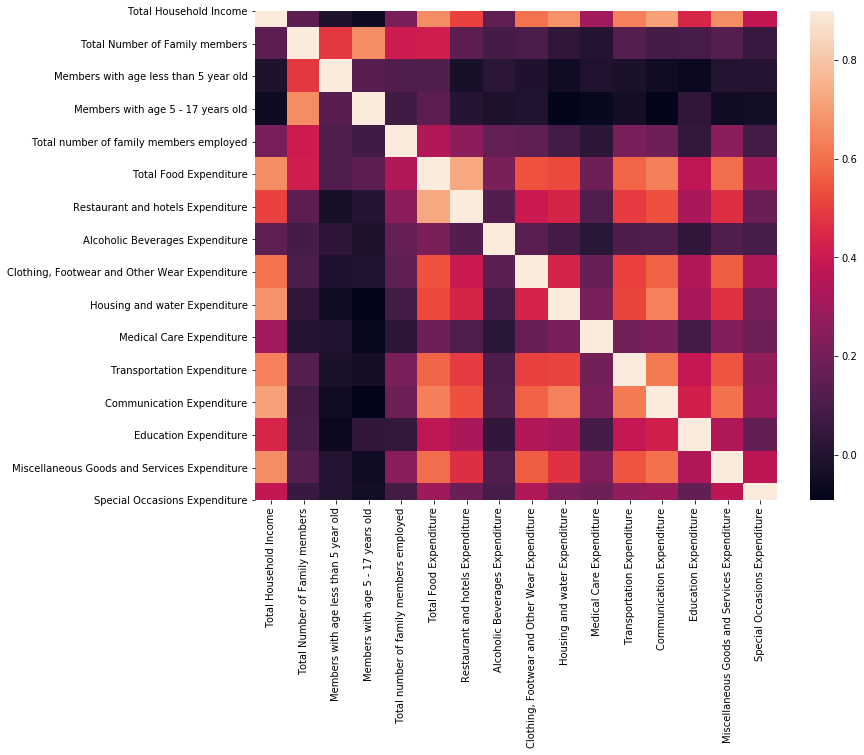

In [10]:
# Mapa de calor  de correlações cruzadas

corrmat = df_tri.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

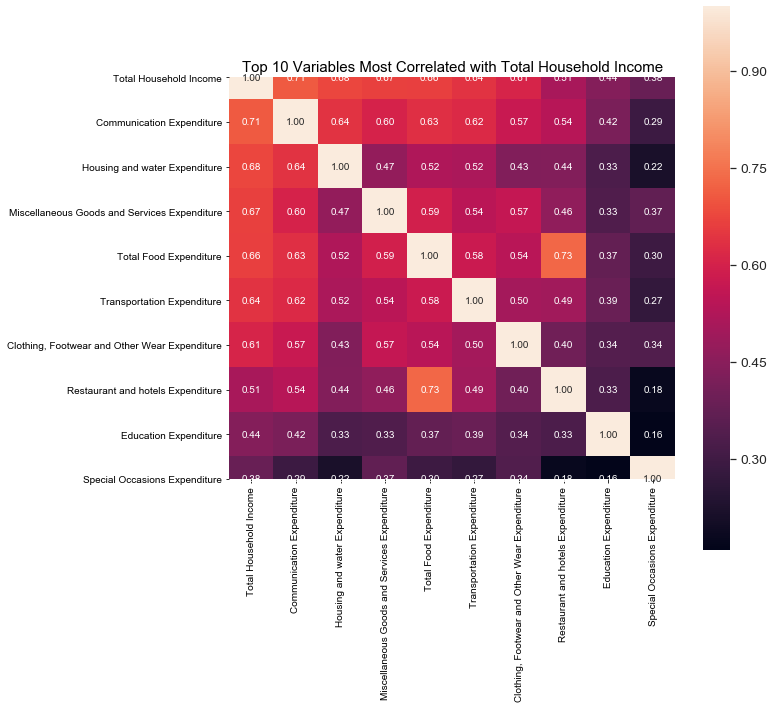

In [11]:
# 10 Variáveis com maior correlação à 'Total Household Income'

k = 10
corrmat = df_tri.corr()
cols = corrmat.nlargest(k, target)[target].index
f, ax = plt.subplots(figsize=(10, 10))
cm = np.corrcoef(df_tri[cols].values.T)
sns.set(font_scale=1.25)
s = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
s.set_title("Top 10 Variables Most Correlated with Total Household Income", size=15)
plt.show()

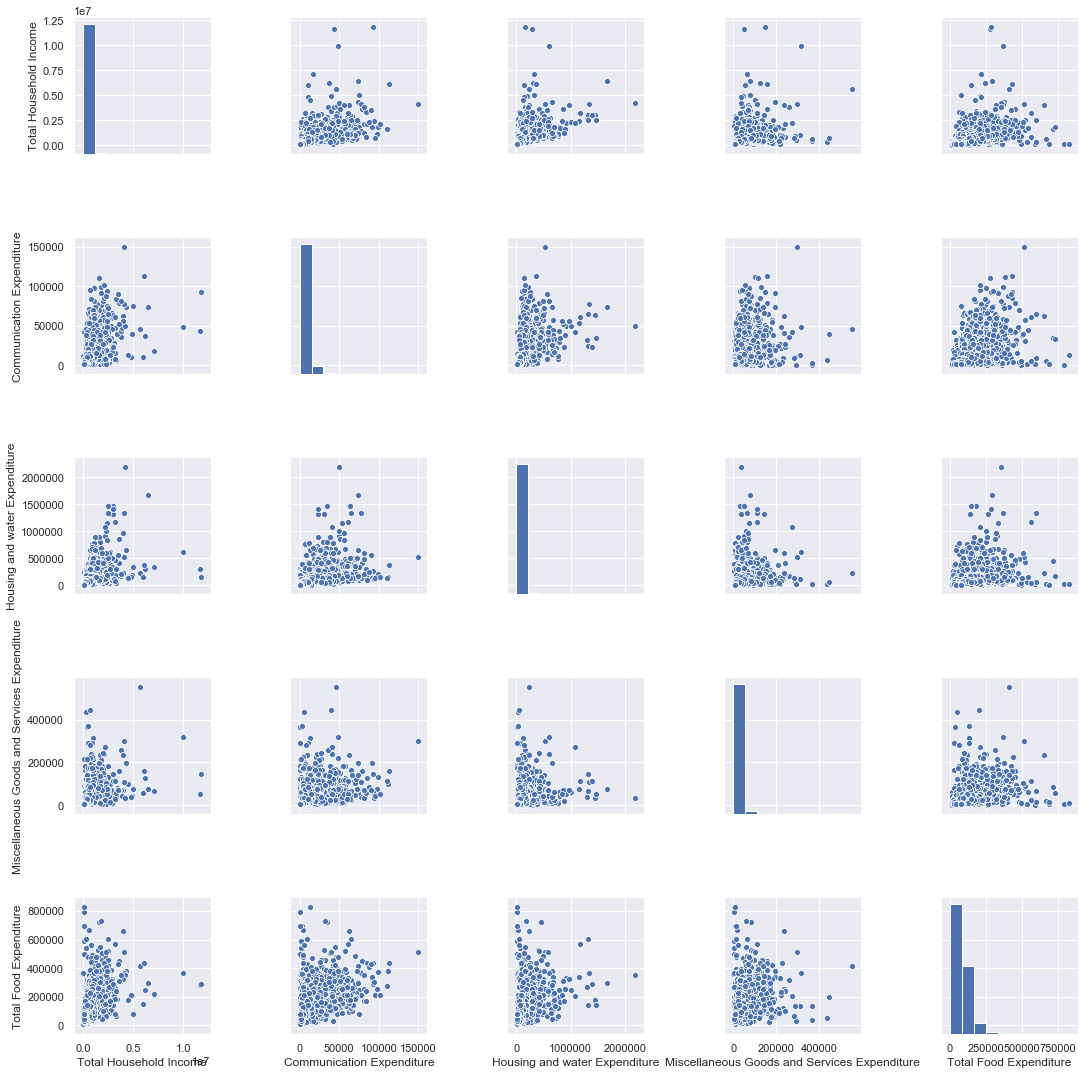

In [12]:
# Relações de pares de variáveis

sns.set()
sns.pairplot(df_tri[cols[:5]], height = 3)
plt.show()

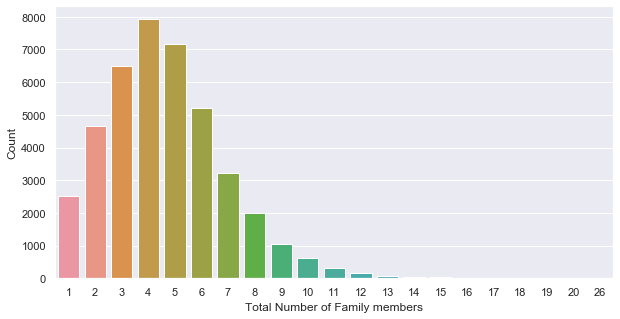

In [13]:
var = 'Total Number of Family members'
fig, ax = plt.subplots(figsize=(10,5))
s = sns.countplot(x=var, data=df_tri)
s.set(ylabel='Count')
plt.show()

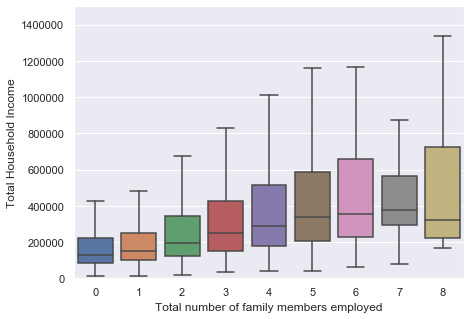

In [14]:
var = 'Total number of family members employed'
fig, ax = plt.subplots(figsize=(7,5))
s = sns.boxplot(x=var, y=target, data=df_tri, fliersize=0)
s.set(ylabel=target)
s.set_ylim(0,1.5*10**6)
plt.show()

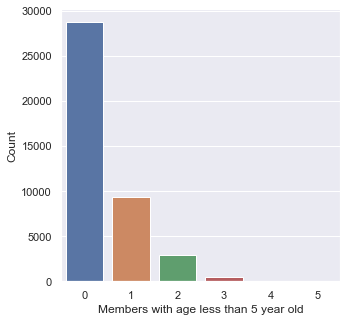

In [15]:
var = 'Members with age less than 5 year old'
fig, ax = plt.subplots(figsize=(5,5))
s = sns.countplot(x=var, data=df)
s.set(ylabel='Count')
plt.show()

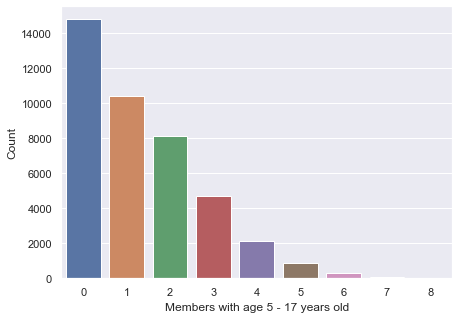

In [16]:
var = 'Members with age 5 - 17 years old'
fig, ax = plt.subplots(figsize=(7,5))
s = sns.countplot(x=var, data=df_tri)
s.set(ylabel='Count')
plt.show()

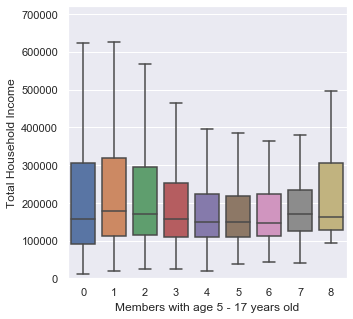

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
s = sns.boxplot(x=var, y=target, data=df_tri, fliersize=0)
s.set_ylim(0,720000)
plt.show()

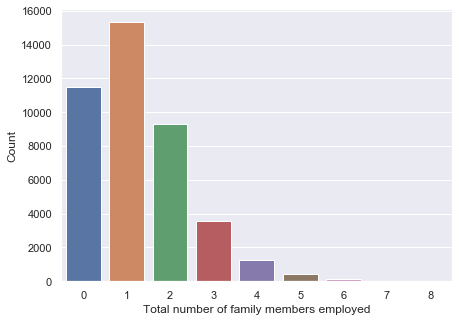

In [18]:
var = 'Total number of family members employed'
fig, ax = plt.subplots(figsize=(7,5))
s = sns.countplot(x=var, data=df_tri)
s.set(ylabel='Count')
plt.show()

## Obs:

O gráfico circular utilizado abaixo permite comparar perfil de gastos categóricos por região. Nela pode-se identificar certas tendências como valor de gastos com comida independe da região. Algumas regiões possuem gastos com moradias bem mais relevantes que outras. Ainda, pode-se notar que a região NCR possui todos os gastos acima da média e gastos muito acima da média em categorias como ocasião especial e transportes. Essas variações devem-se, provavelmente, a desigualdade de renda entre as regiões. Esta informação é extremamente importante para o nosso projeto, entretanto não a utilizaremos dado que este é apenas um protótipo e a complexidade de sua utilização. 

In [19]:
# Source: https://stackoverflow.com/questions/42227409/tutorial-for-python-radar-chart-plot
def radar_plot():
    
    regions = df['Region'].astype('category').cat.categories.tolist()
    region_dict = {i:region for i,region in enumerate(regions)}
    fig, ax = plt.subplots(int(len(regions)) , 1)
    fig.subplots_adjust(hspace=0.5)
    fig.set_figheight(100)
    fig.set_figwidth(100)

    for i in range(0, len(regions)):
        title = region_dict[i]
        var = 'Region'
        regions = df['Region'].astype('category').cat.categories.tolist()
        cat = [c for c in df.columns if ('Expenditure' in c)]
        values = [df[df[var]==regions[i]][c].mean() for c in cat]

        N = len(cat)
        x_as = [n / float(N) * 2 * pi for n in range(N)]
        values += values[:1]
        x_as += x_as[:1]

        # Set color of axes
        plt.rc('axes', linewidth=0.5, edgecolor="#888888")

        # Create polar plot
        ax = plt.subplot(int(len(regions)), 1, i+1, polar=True)

        # Set clockwise rotation. That is:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # Set position of y-labels
        ax.set_rlabel_position(0)

        # Set color and linestyle of grid
        ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
        ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)

        # Set number of radial axes and remove labels
        plt.xticks(x_as[:-1], [])

        # Set yticks
        max_ = 11
        plt.yticks([x*10000 for x in range(1,max_+1) if x %2 == 0], [str(x)+ "e4"for x in range(1,max_+1) if x %2 == 0], size=10)

        # Plot data
        ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)

        # Fill area
        ax.fill(x_as, values, 'b', alpha=0.5)

        # Set axes limits
        max_val = max_*10000
        plt.ylim(0, max_val)

        # Draw ytick labels to make sure they fit properly
        for i in range(N):
            angle_rad = i / float(N) * 2 * pi

            if angle_rad == 0:
                ha, distance_ax = "center", 15000
            elif 0 < angle_rad < pi:
                ha, distance_ax = "left", 100
            elif angle_rad == pi:
                ha, distance_ax = "center", 15000
            else:
                ha, distance_ax = "right", 100

            ax.text(angle_rad, max_val + distance_ax + 15000, cat[i], size=10, horizontalalignment=ha, verticalalignment="center")

        plt.title('Expenditures of Region ' + title)

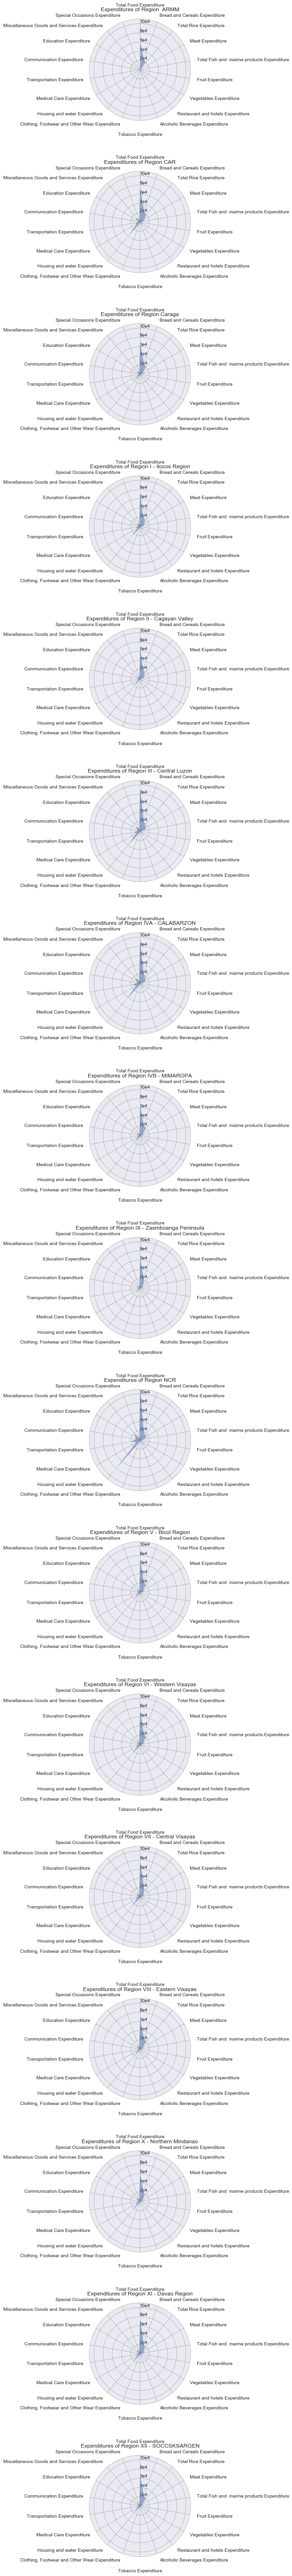

In [20]:
radar_plot()
plt.show()

In [21]:
features_in = ['Total Household Income', 
                'Total Number of Family members',
                'Members with age less than 5 year old',
                'Members with age 5 - 17 years old',
               'Total number of family members employed']

df_in = df[features_in]

features2pred = ['Total Food Expenditure', 
       'Restaurant and hotels Expenditure',
       'Clothing, Footwear and Other Wear Expenditure',
       'Housing and water Expenditure', 
       'Medical Care Expenditure', 
       'Transportation Expenditure',
       'Communication Expenditure', 
       'Education Expenditure',
       'Miscellaneous Goods and Services Expenditure',
       'Alcoholic Beverages Expenditure',
       'Special Occasions Expenditure']

#target = 'Communication Expenditure'
#y = df_tri[target]
X = df_in

In [22]:
# Pre processamento de dados: centralização e escalonamento

cols = list(X.columns)
std_scale = preprocessing.StandardScaler().fit(X[cols])
X[cols] = pd.DataFrame(std_scale.transform(X[cols]), columns=cols)

C:\Users\vitin\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 5 columns):
Total Household Income                     41544 non-null float64
Total Number of Family members             41544 non-null float64
Members with age less than 5 year old      41544 non-null float64
Members with age 5 - 17 years old          41544 non-null float64
Total number of family members employed    41544 non-null float64
dtypes: float64(5)
memory usage: 1.6 MB


In [24]:
X.describe(include='all')

,Total Household Income,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed
count,4.154400e+04,4.154400e+04,4.154400e+04,4.154400e+04,4.154400e+04
mean,-1.801079e-16,-1.062799e-15,2.479103e-15,2.228188e-15,3.918427e-15
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-8.235952e-01,-1.594221e+00,-5.907639e-01,-9.677529e-01,-1.107525e+00
25%,-4.972882e-01,-7.171145e-01,-5.907639e-01,-9.677529e-01,-1.107525e+00
50%,-2.909821e-01,-2.785612e-01,-5.907639e-01,-2.575170e-01,-2.373073e-01
75%,1.519219e-01,5.985455e-01,8.493661e-01,4.527190e-01,6.329103e-01
max,4.032540e+01,9.369613e+00,6.609886e+00,4.714135e+00,5.854216e+00


In [25]:
# Utiliza técnica de PCA para fazer redução de dimensão no espaço vetorial de 5 para 3

pca = PCA(n_components=3)
pca.fit(X)
X_reduced = pca.transform(X)

print('Shape of X:', X.shape)
print('Shape of X_reduced:', X_reduced.shape)

Shape of X: (41544, 5)
Shape of X_reduced: (41544, 3)


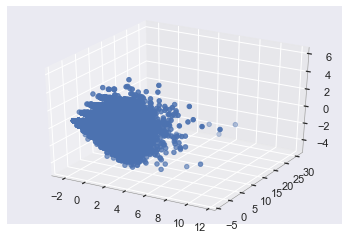

In [27]:
# Plot no espaço tridimensional. Cada ponto corresponde a uma amostra (família filipina)

fig = plt.figure()
ax = plt.axes(projection='3d')
x1 = X_reduced[:,0]
x2 = X_reduced[:,1]
x3 = X_reduced[:,2]
ax.scatter3D(x1, x2, x3, cmap='Greens');
#Axes3D.scatter(x1,x2,x3)

In [28]:
# Utilização de algoritmo de clustering para dividir usuários em 3 grupos de maior semelhança

k_means = cluster.KMeans(n_clusters=3)
X_cluster = k_means.fit_predict(X_reduced)

#print(X_cluster.shape)
#print(X_cluster)
#print(y.shape)

In [38]:
def plot_category(X_red, X_cluster, df_tri, target):
    test_size = 0.2
    seed = 42
    y = df_tri[target]
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=test_size, random_state=seed)
    _, _, X_cluster_train, X_cluster_test = train_test_split(X_red, X_cluster, test_size=test_size, random_state=seed)

    mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b'])

    x_c1_train = X_train[X_cluster_train==0,0]
    x_c2_train = X_train[X_cluster_train==1,0]
    x_c3_train = X_train[X_cluster_train==2,0]

    y_c1_train = y_train[X_cluster_train==0]
    y_c2_train = y_train[X_cluster_train==1]
    y_c3_train = y_train[X_cluster_train==2]

    x_c1_test = X_test[X_cluster_test==0,0]
    x_c2_test = X_test[X_cluster_test==1,0]
    x_c3_test = X_test[X_cluster_test==2,0]

    y_c1_test = y_test[X_cluster_test==0]
    y_c2_test = y_test[X_cluster_test==1]
    y_c3_test = y_test[X_cluster_test==2]
    
    figure = plt.figure(figsize=(6, 6))
    plt.scatter(x_c1_test, y_c1_test, alpha=0.4)
    plt.scatter(x_c2_test, y_c2_test, alpha=0.4)
    plt.scatter(x_c3_test, y_c3_test, alpha=0.4)

    reg1 = LinearRegression().fit(x_c1_train.reshape(-1,1), y_c1_train)
    y_c1_pred = reg1.predict(x_c1_test.reshape(-1,1))

    reg2 = LinearRegression().fit(x_c2_train.reshape(-1,1), y_c2_train)
    y_c2_pred = reg2.predict(x_c2_test.reshape(-1,1))

    reg3 = LinearRegression().fit(x_c3_train.reshape(-1,1), y_c3_train)
    y_c3_pred = reg3.predict(x_c3_test.reshape(-1,1))

    plt.plot(x_c1_test, y_c1_pred, color='red', linewidth=2)
    plt.plot(x_c2_test, y_c2_pred, color='green', linewidth=2)
    plt.plot(x_c3_test, y_c3_pred, color='blue', linewidth=2)

    plt.xticks(())
    plt.yticks(())
    plt.title('{} prediction for 3 clusters'.format(target))
    plt.xlabel('Total Income')
    plt.ylabel(target)

    #plt.show()
    return figure

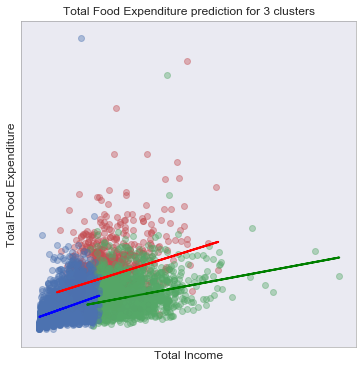

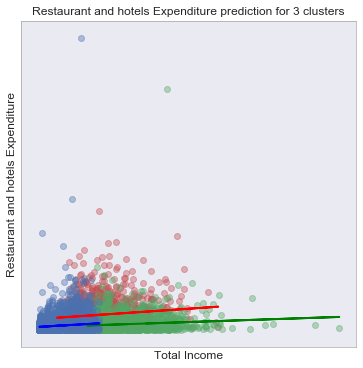

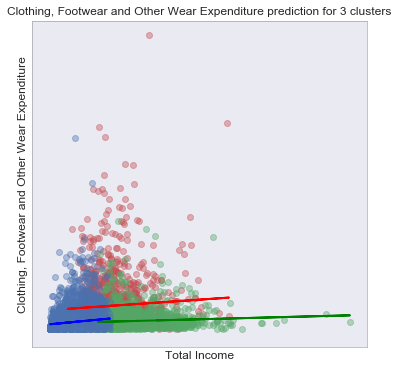

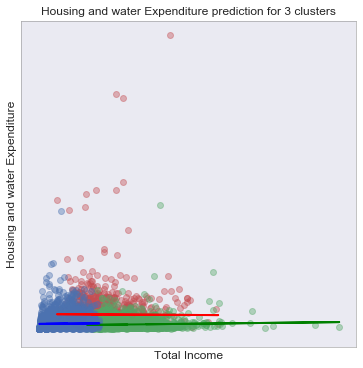

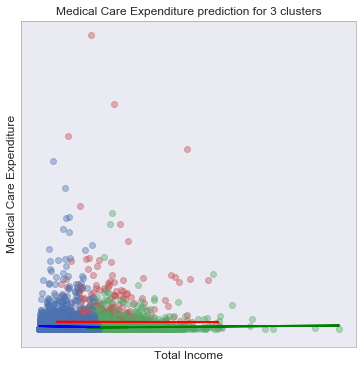

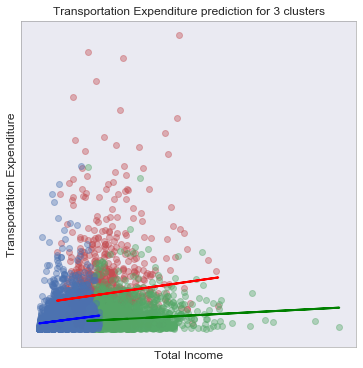

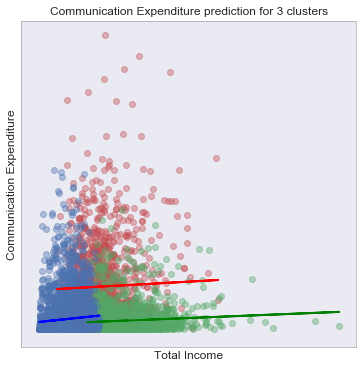

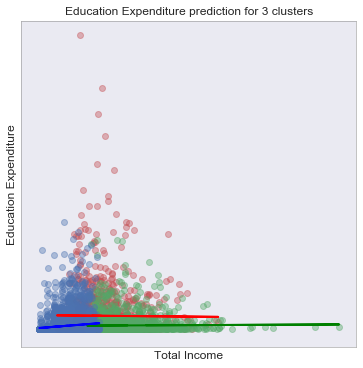

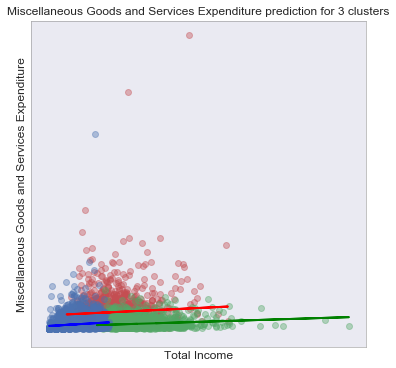

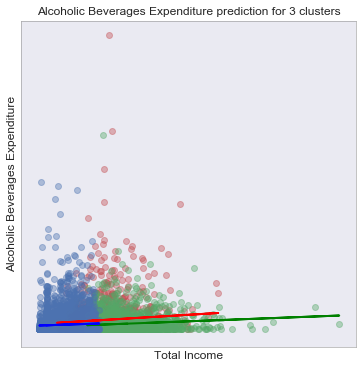

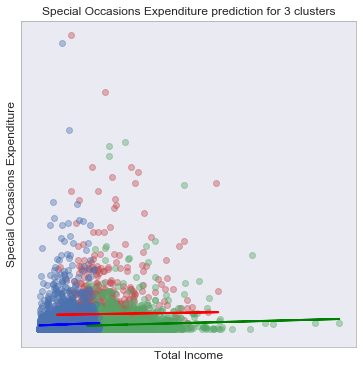

In [40]:
for target in features2pred:
    fig = plot_category(X_reduced, X_cluster, df_tri, target)
    plt.show(fig)